# Problem 1

In [2]:
#Tech stuff
import scipy
from scipy.io import wavfile
from scipy.signal import resample
import numpy as np
%matplotlib inline
import sys
def load_wav(filename,samplerate=44100):
    
    # load file
    rate, data = wavfile.read(filename)

    # convert stereo to mono
    if len(data.shape) > 1:
        data = data[:,0]/2 + data[:,1]/2

    # re-interpolate samplerate    
    ratio = float(samplerate) / float(rate)
    data = resample(data, len(data) * ratio)
    
    return samplerate, data.astype(np.int16)

In [16]:
#Reading the wavefile
import StringIO
import base64
import struct  

from IPython.core.display import HTML
from IPython.core.display import display
def wavPlayer(data, rate):
    """ will display html 5 player for compatible browser
    The browser need to know how to play wav through html5.
    there is no autoplay to prevent file playing when the browser opens
    Adapted from SciPy.io. and
    github.com/Carreau/posts/blob/master/07-the-sound-of-hydrogen.ipynb
    """
    
    buffer = StringIO.StringIO()
    buffer.write(b'RIFF')
    buffer.write(b'\x00\x00\x00\x00')
    buffer.write(b'WAVE')

    buffer.write(b'fmt ')
    if data.ndim == 1:
        noc = 1
    else:
        noc = data.shape[1]
    bits = data.dtype.itemsize * 8
    sbytes = rate*(bits // 8)*noc
    ba = noc * (bits // 8)
    buffer.write(struct.pack('<ihHIIHH', 16, 1, noc, rate, sbytes, ba, bits))

    # data chunk
    buffer.write(b'data')
    buffer.write(struct.pack('<i', data.nbytes))

    if data.dtype.byteorder == '>' or (data.dtype.byteorder == '=' and sys.byteorder == 'big'):
        data = data.byteswap()

    buffer.write(data.tostring())
    # return buffer.getvalue()
    # Determine file size and place it in correct
    # position at start of the file.
    size = buffer.tell()
    buffer.seek(4)
    buffer.write(struct.pack('<i', size-8))
    
    val = buffer.getvalue()
    
    src = """
    <head>
    <meta http-equiv="Content-Type" content="text/html; charset=utf-8">
    <title>Simple Test</title>
    </head>
    
    <body>
    <audio controls="controls" style="width:600px" >
      <source controls src="data:audio/wav;base64,{base64}" type="audio/wav" />
      Your browser does not support the audio element.
    </audio>
    </body>
    """.format(base64=base64.encodestring(val))
    display(HTML(src))

C:\Users\Evgeny\Anaconda2\lib\site-packages\scipy\signal\signaltools.py:1889: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  Y = zeros(newshape, 'D')


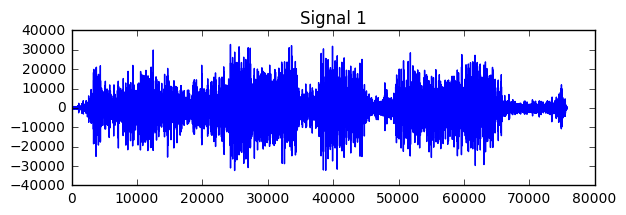

NameError: name 'wavPlayer' is not defined

In [4]:
#The first sound
import pylab as pl
import numpy as np
# load
fs1,s1 = load_wav('TMaRdy00.wav') # Terran Battlecruiser - "Good day, commander."

# plot
pl.figure(figsize=(6.75,2))
pl.plot(s1)
pl.title('Signal 1')
pl.show()

# player
wavPlayer(s1, fs1)

In [18]:
megabytes = s1.dtype.itemsize * len(s1) / float(10**6)
print megabytes


0.151552


In [19]:
def gen_toeplitz(N, a):
    T = np.arange(N) #array generating
    Tij = scipy.linalg.toeplitz(T) #matrix Tij = |i-j|
    Tij = Tij * Tij # matrix Tij = (i-j)^2
    Tij = np.sqrt(a / np.pi) * np.exp (- a * Tij)
    return Tij

In [20]:
p = 20
signal_pcut = s1[::p] #signall cutting

# Convolution 

In [21]:
T1 = gen_toeplitz(len(signal_pcut), 0.2) #Toeplitz matrix with a = 0.2
T2 = gen_toeplitz(len(signal_pcut), 0.01) #Toeplitz matrix with a = 0.01

In [22]:
T1_dot_signal_pcut = np.dot(T1, signal_pcut) #Multiplying signal_pcut by Toeplitz matrix with a = 0.2
T2_dot_signal_pcut = np.dot(T2, signal_pcut) #Multiplying signal_pcut by Toeplitz matrix with a = 0.01

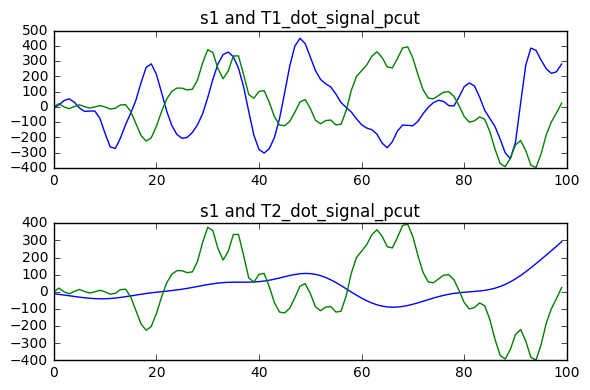

In [23]:
pl.subplot(2,1,1)
pl.plot(T1_dot_signal_pcut[:100])
pl.plot(s1[:100])
pl.title('s1 and T1_dot_signal_pcut')


pl.subplot(2,1,2)
pl.plot(T2_dot_signal_pcut[:100])
pl.plot(s1[:100])
pl.title('s1 and T2_dot_signal_pcut')
pl.tight_layout()
pl.show()

In [24]:
frequency = fs1 / p

In [ ]:
T1_dot_signal_pcut = T1_dot_signal_pcut.astype(np.int16)
wavPlayer(T1_dot_signal_pcut, frequency)

In [ ]:
T2_dot_signal_pcut = T2_dot_signal_pcut.astype(np.int16)
wavPlayer(T2_dot_signal_pcut, frequency)

# Deconvolution

We have an optimization problem


$$||Tx_{k+1} - y|| \rightarrow \min{\tau_k}$$


Substituting the expression for $x_{k+1}$ in $||Tx_{k+1} - y||^2$ we obtain


$$||Tx_{k+1} - y||^2 = \langle r_k, r_k\rangle - 2\tau_k\langle r_k, Tr_k\rangle + \tau_k^2\langle Tr_k, Tr_k\rangle$$


Taking a derivative with respect to $\tau_k$ and putting it to zero we obtain


$$\tau_k\langle Tr_k, Tr_k\rangle = \langle r_k, Tr_k\rangle$$


So we can find an optimal point $\tau_k$


$$\tau_k = \frac{\langle r_k, Tr_k\rangle}{\langle Tr_k, Tr_k\rangle}$$

In [43]:
def iterative(N, num_iter, y, a):
    T = gen_toeplitz(N, a)
    x = np.dot(np.linalg.inv(T), y)
    x_iter = np.zeros(N)
    mis = []
    for i in range(num_iter):
        r = T.dot(x_iter) - y
        T_dot_r = T.dot(r)
        tau = r.dot(T_dot_r) / (T_dot_r.dot(T_dot_r))
        x_iter = x_iter - tau * r
        mis.append(np.linalg.norm(x_iter - x)/np.linalg.norm(x))
    return np.array(mis)

In [44]:
# Computing for a = 0.5

N, a = len(signal_pcut), 0.5

#In this case y = Toeplitz(N, a) * signal_pcut
T = gen_toeplitz(N, a)
y = np.dot(T, signal_pcut)

# So we obtain an array of mistakes
mis1 = iterative(N, 1000, y, a)

In [45]:
# Computing for a = 0.2

N, a = len(signal_pcut), 0.2

#In this case y = Toeplitz(N, a) * signal_pcut
T = gen_toeplitz(N, a)
y = np.dot(T, signal_pcut)

# So we obtain an array of mistakes
mis2 = iterative(N, 1000, y, a)

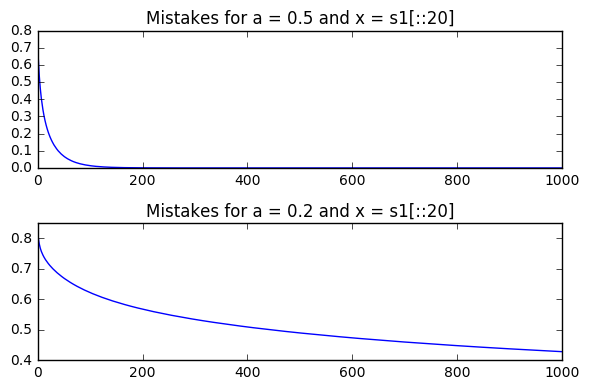

In [69]:
# Plots

pl.subplot(2,1,1)
pl.plot(mis1)
pl.title('Mistakes for a = 0.5 and x = s1[::20]')

pl.subplot(2,1,2)
pl.plot(mis2)
pl.title('Mistakes for a = 0.2 and x = s1[::20]')

pl.tight_layout()
pl.show()

In [66]:
N = len(signal_pcut); a = 0.2

#Generating a Toeplitz matrix and y
T = gen_toeplitz(N, a)
y = np.dot(T, signal_pcut)

#Adding a random noise
y += np.random.normal(0, max(signal_pcut) * 0.001, N)

#Mistakes array
mis = iterative(N, 1000, y, a)

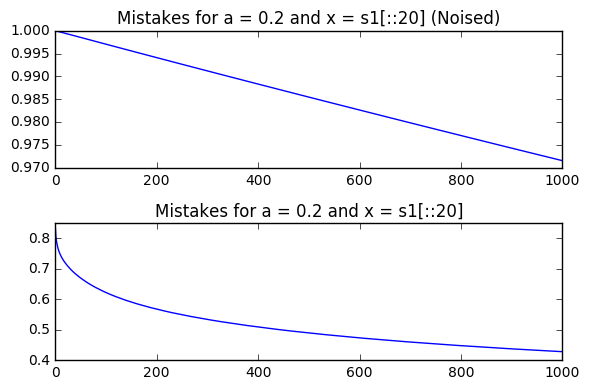

In [70]:
# Plots

pl.subplot(2,1,1)
pl.plot(mis)
pl.title('Mistakes for a = 0.2 and x = s1[::20] (Noised)')

pl.subplot(2,1,2)
pl.plot(mis2)
pl.title('Mistakes for a = 0.2 and x = s1[::20]')

pl.tight_layout()
pl.show()

# Problem 2 
## Unitary invariance

1) $$||Ux||_2 = \langle Ux , Ux\rangle = x^* U^*Ux = x^*x = ||x||_2$$


2) $$||UAV||_2 = \max_{||x||\neq 0 }\frac{||UAVx||_2}{||x||_2} = \max_{||x||\neq 0 }\frac{x^*V^*A^*U^*UAVx}{||x||_2} =\max_{||x||\neq 0 }\frac{x^*V^*A^*AVx}{||x||_2} =  \max_{||x||\neq 0 }\frac{||AVx||}{||x||_2} = \max_{||x||\neq 0 }\frac{||AVx||_2}{||Vx||_2} = \max_{||x||\neq 0 }\frac{||Ax||_2}{||x||_2}$$

3) $$(AB)_{ij} = \sum_k A_{ik}B_{kj}\Rightarrow(AA^*)_{ij} = \sum_k A_{ik}\overline{A_{jk}}$$

so the trace of $AA^*$ is

$$trace(AA^*) = \sum_i (AA^*)_{ii} = \sum_i \sum_k A_{ik}\overline{A_{ik}} = \sum_{i,k} |A_{ik}|^2 = ||A||_F^2.$$


Here is a proof of $trace(AB) = trace(BA)$:


$$trace(AB) = \sum_i (AB)_{ii} = \sum_i \sum_k A_{ik}B_{ki} = \sum_k \sum_i A_{ik}B_{ki} = \sum_k \sum_i B_{ki}A_{ik} = \sum_k (BA)_{kk} = trace(BA)$$


4) $$||UAV||_F^2 = trace(UAVV^*A^*U^*) = trace(UAA^*U^*) = trace(A^*U^*UA) = trace(A^*A) = trace(AA^*) = ||A||_F^2$$

## SVD

1) Spectral norm:

$$\max_{||x||_2\neq 0 }\frac{||Ax||_2}{||x||_2} = \max_{||x||_2\neq 0 }\frac{\sqrt{\langle Ax, Ax\rangle}}{||x||_2} = \max_{||x||_2\neq 0 }\frac{\sqrt{\langle x, A^*Ax\rangle}}{||x||_2} = \max_{||x||_2\neq 0 }\frac{\sqrt{||x||_2\cdot||A^*Ax||_2\cdot \cos(\alpha)}}{||x||_2}$$

where $\alpha$ - is an angle between vectors $x$ and $A^*Ax$. Obviously, the maximun is obtained when $\cos(\alpha)=1$. This case is achieved when $x$ is an eigenvector of $A^*A$. Finally, we have to choose eigenvector with $\lambda_{max}$. So we obtain

$$\max_{||x||_2\neq 0 }\frac{||Ax||_2}{||x||_2} = \sqrt{\lambda_{max}(A^*A)} = \sigma_1(A)$$

Frobenius norm:

$$||A||_F = \sqrt{trace(A^*A)} = \sqrt{\sum_i \lambda_i(A^*A)} = \sqrt{\sum_i \sigma_i(A)^2}$$


2) Unitary invariance of nuclear norm:

$$||UAV||_* = \sum_i \sqrt{\lambda_i(V^*A^*U^*UAV)} = \sum_i \sqrt{\lambda_i(V^*A^*AV)}$$

If $x$ is an eigenvector of $V^*A^*AV$ then $Vx$ is an eigenvector of $A^*A$, more precisely 

$$V^*A^*AV = \lambda x\Rightarrow (AA^*)Vx = \lambda Vx$$


Hence,

$$||UAV||_* = \sum_i \sqrt{\lambda_i(V^*A^*AV)} = \sum_i \sqrt{\lambda_i(AA^*)} = ||A||_*$$

**Bonus**:

* $$||A||_* = 0\Rightarrow \lambda_i(A^*A) = 0,\ \forall i\ \ \Rightarrow trace(A^*A) = 0\Rightarrow \sum_{i,j}|(A)_{ij}|^2 = 0 \Rightarrow A_{ij} = 0$$

* $$||\alpha A||_* = \sum_i \sqrt{\lambda_i(|\alpha|^2 A^*A)} = \sum_i \sqrt{|\alpha|^2 \lambda_i(A^*A)} = \sum_i |\alpha| \sqrt{ \lambda_i(A^*A)} = |\alpha| \sum_i \sqrt{ \lambda_i(A^*A)} = |\alpha| \cdot ||A||_*$$





# Problem 3


# Problem 4

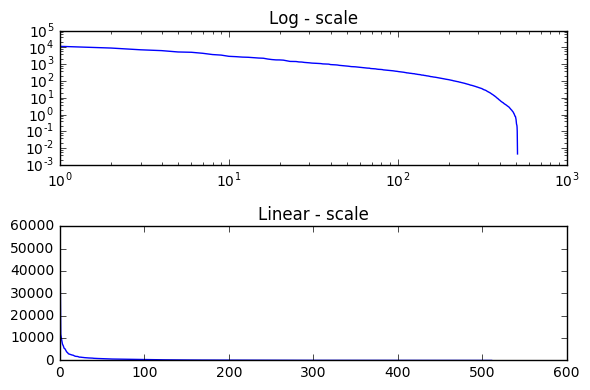

In [5]:
from PIL import Image
lena = Image.open('lenaTest3.jpg')
lena_svd = np.linalg.svd(lena)# Computing SVD

pl.subplot(2,1,1)
pl.plot(lena_svd[1])
pl.title('Log - scale')
pl.xscale('log')
pl.yscale('log')

pl.subplot(2,1,2)
pl.plot(lena_svd[1])
pl.title('Linear - scale')

pl.tight_layout()
pl.show()

In [7]:
r = [5, 20, 50, 512]

# pl.subplot(2,2,1)
# lena_compr_r = np.dot(np.dot(lena_svd[0][:,:r[0]], np.diag(lena_svd[1][:r[0]])), lena_svd[2][:r[0],:])
# pl.imshow(lena_compr_r, cmap = 'gray')

# pl.subplot(2,2,2)
# lena_compr_r = np.dot(np.dot(lena_svd[0][:,:r[1]], np.diag(lena_svd[1][:r[1]])), lena_svd[2][:r[1],:])
# pl.imshow(lena_compr_r, cmap = 'gray')

# pl.subplot(2,2,3)
# lena_compr_r = np.dot(np.dot(lena_svd[0][:,:r[2]], np.diag(lena_svd[1][:r[2]])), lena_svd[2][:r[2],:])
# pl.imshow(lena_compr_r, cmap = 'gray')

# pl.subplot(2,2,4)
# lena_compr_r = np.dot(np.dot(lena_svd[0][:,:r[3]], np.diag(lena_svd[1][:r[3]])), lena_svd[2][:r[3],:])
# pl.imshow(lena_compr_r, cmap = 'gray')


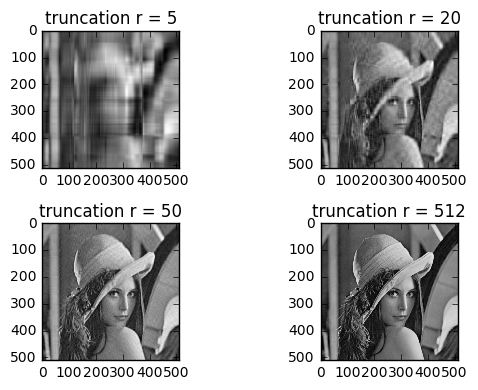

In [8]:
for i in range(len(r)):
    pl.subplot(2, 2, i+1)
    pl.title(("truncation r = %s") % r[i])
    lena_compr_r = np.dot(np.dot(lena_svd[0][:,:r[i]], np.diag(lena_svd[1][:r[i]])), lena_svd[2][:r[i],:])
    pl.imshow(lena_compr_r, cmap = 'gray')
    
pl.tight_layout()

# Problem 5

* Spectral norm is not an absolute norm.

$$\left|\left| \begin{bmatrix}
4 && 7 \\
10 && -5
\end{bmatrix} \right|\right|_2 = 9$$

$$\left|\left| \begin{bmatrix}
4 && 7 \\
10 && 5
\end{bmatrix} \right|\right|_2 = 12.8815$$


In [52]:
noise = np.random.normal(0, max(signal_pcut) * 0.001, 100)

In [53]:
noise

array([ -23.5975789 ,    9.82785527,   -2.9274986 ,  -45.17487652,
         -8.72836819,   16.64995547,    6.53907868,   21.0388558 ,
          8.57088632,   31.5393935 ,   35.47931072,   10.52227652,
          7.76632209,   -9.44050327,  -49.17966279,  -23.90883403,
         -4.11507428,  -25.81692383,  -25.13383595,   16.67754547,
          8.16796537,   22.89860494,  -17.10882632,   -5.90727447,
          2.29811305,   44.1747024 ,  -63.88489262,   -4.02611093,
        -52.36556658,   -8.71873896,   72.01933361,   64.00347603,
        -24.89905403,   13.32032971,   28.66721353,  -10.10358626,
        -42.25878402,  -23.63001763,  -67.2472629 ,  -41.33126263,
        -59.99554094,   56.47482737,    9.20866815,  -45.35478161,
         -0.93660244,   18.45644142,   -2.89089956,  -58.18872335,
        -22.12955805,  -10.9206207 ,   14.32208724,  114.98668265,
         10.25981456,   26.49688508,   12.9964353 ,   12.08109851,
          9.08866743,  -70.48164811,   -7.79920707,   13.78942